In [175]:
import os
import numpy as np

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import pandas as pd

import time
import matplotlib.pyplot as plt

In [138]:
ca_bound = {'bottom': 32.0, 'top': 42.1, 'left': -124.6, 'right': -114.2}

In [200]:
## CA boundary shapefile

datapath = '/home/jing/data_explore/data/cal/CA_Counties'
ca = gpd.read_file(datapath).to_crs(epsg=4326)

## NetCDF

In [179]:
import Nio

In [2]:
ffolder = '/data/fire_topdown/GridMet'
fname = 'vs_2015.nc'
f_vs = Nio.open_file(os.path.join(ffolder, fname))

In [3]:
f_vs.variables.keys()

dict_keys(['lon', 'lat', 'day', 'crs', 'wind_speed'])

In [7]:
## variables we need

lat = f_vs.variables['lat'].get_value()
lon = f_vs.variables['lon'].get_value()
vs = f_vs.variables['wind_speed'].get_value()

f_vs.close()

In [35]:
## to dataframe

lon_2d, lat_2d = np.meshgrid(lon, lat)

lon_l = lon_2d.flatten()
lat_l = lat_2d.flatten()
vs_l = vs.reshape(vs.shape[0], -1).T
# print(vs_l.shape, lat_l.shape)
df_vs = pd.DataFrame({'lat': lat_l, 'lon': lon_l})
df_vs['vs'] = vs_l.tolist()

,lat,lon,vs
0,49.4,-124.766667,"[None, None, None, None, None, None, None, Non..."
1,49.4,-124.725000,"[None, None, None, None, None, None, None, Non..."
2,49.4,-124.683333,"[None, None, None, None, None, None, None, Non..."


In [37]:
df_vs.head(3)

,lat,lon,vs
0,49.4,-124.766667,"[None, None, None, None, None, None, None, Non..."
1,49.4,-124.725000,"[None, None, None, None, None, None, None, Non..."
2,49.4,-124.683333,"[None, None, None, None, None, None, None, Non..."


In [55]:
## clip image to cal
df_vs_crop = df_vs.loc[(df_vs['lat'] > ca_bound['bottom']) & (df_vs['lat'] < ca_bound['top']) & 
         (df_vs['lon'] > ca_bound['left']) & (df_vs['lon'] < ca_bound['right']), :]

df_vs_crop.head(3)

,lat,lon,vs
243940,42.066667,-124.600000,"[None, None, None, None, None, None, None, Non..."
243941,42.066667,-124.558333,"[None, None, None, None, None, None, None, Non..."
243942,42.066667,-124.516667,"[None, None, None, None, None, None, None, Non..."


## Geotiff

### image clip and re-project


1. Re-project global images and save to /reporject folder
2. Crop global reprojected images within CA lat and lon, save to /crop


In [160]:
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [161]:
def reproject_et(inpath, outpath, new_crs):
    dst_crs = new_crs # CRS for web meractor 

    with rio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)


In [170]:
def clip_geotiff(tiff, bound, out_file):
    """
    input: tiff, geotiff, e.g., 'data/file/in/input.tif'
           box, list, e.g., [20, 30, 40, 50] [bottom, left, top, right]
           out_file: output file, e.g., 'data/file/out/out.tif'
    output: cropped geotiff 
    """
    import earthpy.spatial as es
    from shapely.geometry import box
#     import rasterio as rio
#     from rasterio.plot import plotting_extent
    
    def getFeatures(gdf):
        """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
        import json
        return [json.loads(gdf.to_json())['features'][0]['geometry']]
    
    if (type(bound) == type([])):
        bbox = box(*bound)
#         print(1)
    #     zoom_gpd = gpd.GeoDataFrame()
    #     zoom_gpd.loc[0, 'geometry'] = box(*zoomed_extent)
        zoom = gpd.GeoDataFrame({'geometry': bbox}, index=[0])
    else:
#         print(2)
        zoom = bound
    
    crop, crop_meta = es.crop_image(tiff, zoom)
    crop_affine = crop_meta['transform']
    extent = rio.plot.plotting_extent(crop[0], crop_affine)
    
    meta = tiff.meta.copy()
    meta.update({'transform': crop_affine,
                'height': crop.shape[1],
                'width': crop.shape[2]})
    
    with rio.open(out_file, 'w', **crop_meta) as ff:
        ff.write(crop[0], 1)

In [189]:
atlas_dir = '/data/fire_topdown/GlobalAtlas/CMS_Global_Fire_Atlas/data'
reproject_dir = 'reproject'
crop_dir = 'crop'
file = 'Global_fire_atlas_day_of_burn_yearly_2015.tif'

In [167]:
import time
aim_crs = 'EPSG:4326'
start = time.time()
reproject_et(os.path.join(atlas_dir, file), os.path.join(atlas_dir, reproject_dir, file), aim_crs)
end = time.time()
print(end - start)

53.13469743728638


In [171]:
start = time.time()
with rio.open(os.path.join(atlas_dir, reproject_dir, file)) as ftif:
    # CA bound
    bound = [ca_bound['left'], ca_bound['bottom'], ca_bound['right'], ca_bound['top']]
    # CA shapefile
#     datapath = '/home/jing/data_explore/data/cal/CA_Counties'
#     ca = gpd.read_file(datapath).to_crs(epsg=4326)

    out_f = os.path.join(atlas_dir, crop_dir, file)
    clip_geotiff(ftif, bound, out_f)
end = time.time()
print(end - start)

0.3437681198120117


### Load processed GeoTiff

Processed Geotiff is under crop folder

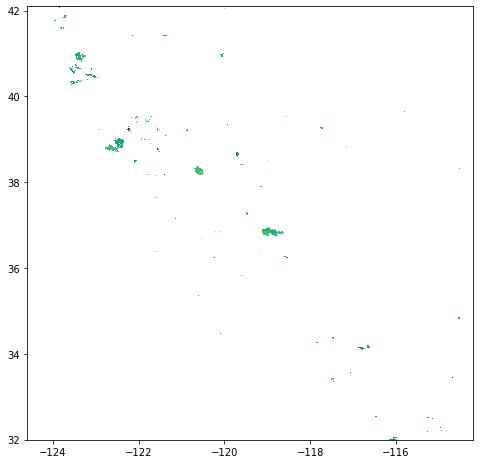

In [178]:
with rio.open(os.path.join(atlas_dir, crop_dir, file)) as ff:
    bound = ff.bounds
    band = ff.read(1, masked=True)
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.imshow(band, extent = plotting_extent(ff))

### Geotiff to Geojson

In [194]:
def geotiff_to_geojson(file):
    """
    input: geotiff
    output: geojson
    """
    
    # Read the dataset's valid data mask as a ndarray.
    mask = file.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rio.features.shapes(
            mask, transform=file.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rio.warp.transform_geom(
            file.crs, 'EPSG:4326', geom, precision=6)
        
        return geom
    

In [196]:
with rio.open(os.path.join(atlas_dir, crop_dir, file)) as ff:
    geoj = geotiff_to_geojson(ff)
    print(geoj)

{'type': 'Polygon', 'coordinates': [[[-123.8716, 42.100097], [-123.8716, 42.095716], [-123.875981, 42.095716], [-123.875981, 42.091335], [-123.8716, 42.091335], [-123.8716, 42.082572], [-123.875981, 42.082572], [-123.875981, 42.078191], [-123.8716, 42.078191], [-123.8716, 42.069429], [-123.867219, 42.069429], [-123.867219, 42.065047], [-123.862837, 42.065047], [-123.862837, 42.056285], [-123.840931, 42.056285], [-123.840931, 42.060666], [-123.83655, 42.060666], [-123.83655, 42.065047], [-123.832169, 42.065047], [-123.832169, 42.07381], [-123.827787, 42.07381], [-123.827787, 42.078191], [-123.832169, 42.078191], [-123.832169, 42.082572], [-123.827787, 42.082572], [-123.827787, 42.086954], [-123.832169, 42.086954], [-123.832169, 42.091335], [-123.827787, 42.091335], [-123.827787, 42.095716], [-123.832169, 42.095716], [-123.832169, 42.100097], [-123.8716, 42.100097]]]}


## Shapefile

In [180]:
import geopandas as gpd

In [184]:
atlas_dir = '/data/fire_topdown/GlobalAtlas/CMS_Global_Fire_Atlas/data'
perimeter = 'perimeter'
file = 'Global_fire_atlas_V1_perimeter_2016.shp'

perimeter = gpd.read_file(os.path.join(atlas_dir, perimeter, file))

In [217]:
len(perimeter)

887251

In [197]:
df_p = perimeter.loc[(perimeter.loc[:, 'lat'] > 32.0) & (perimeter.loc[:, 'lat'] < 42.1) &
              (perimeter.loc[:, 'lon'] > -124.6) & (perimeter.loc[:, 'lon'] < -114.2), :]

In [199]:
perimeter.crs

{'init': 'epsg:4326'}

In [203]:
## Clip by shapefile
poly = ca.geometry.unary_union
clip_poly = df_p[df_p.geometry.intersects(poly)]

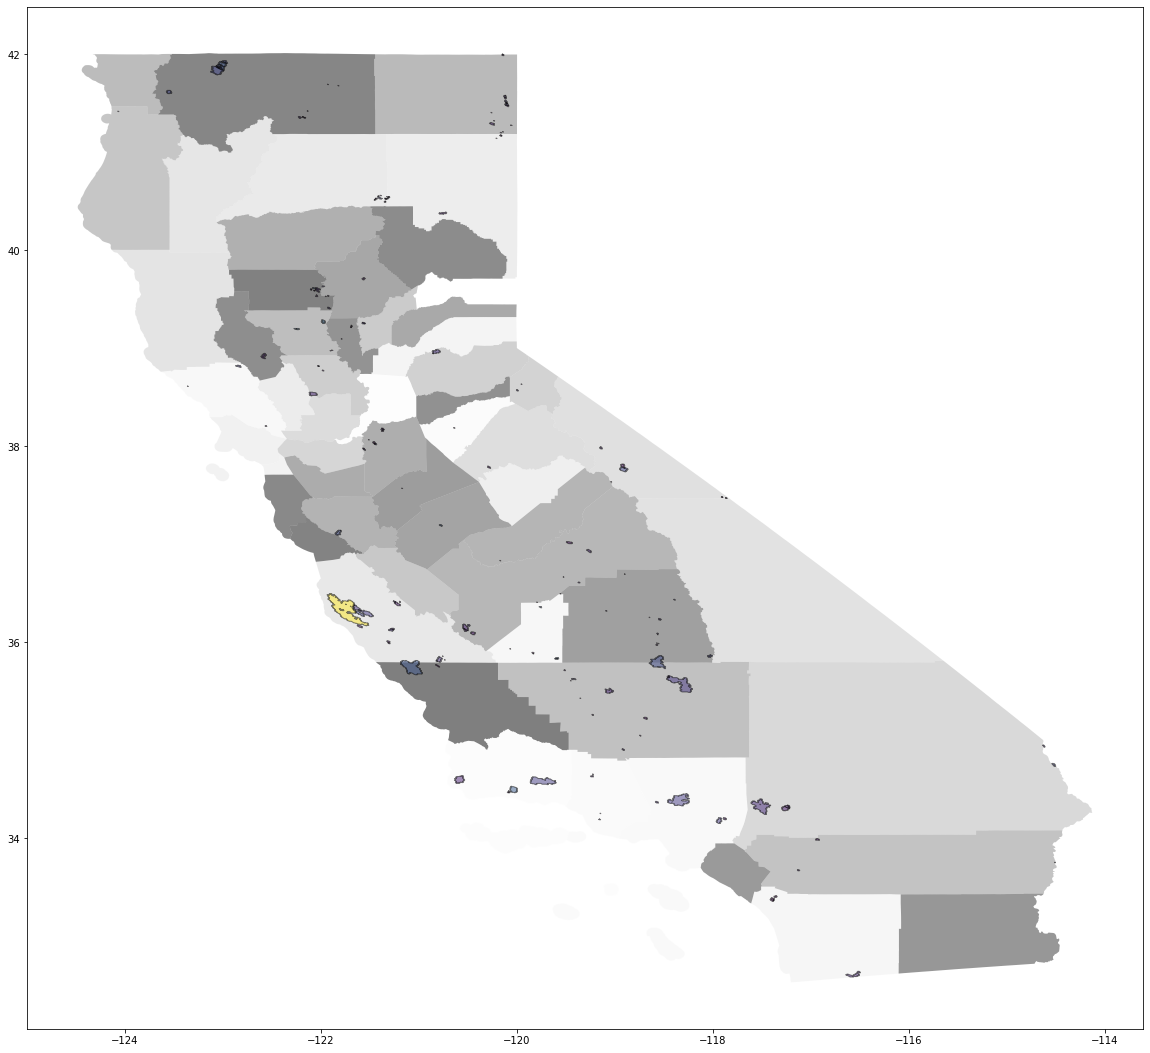

In [206]:
fig, ax = plt.subplots(figsize = (20, 20))
ca.plot(ax = ax, cmap = 'Greys', alpha = 0.5)
clip_poly.plot(ax = ax, column = 'duration', alpha=0.5, edgecolor='k')

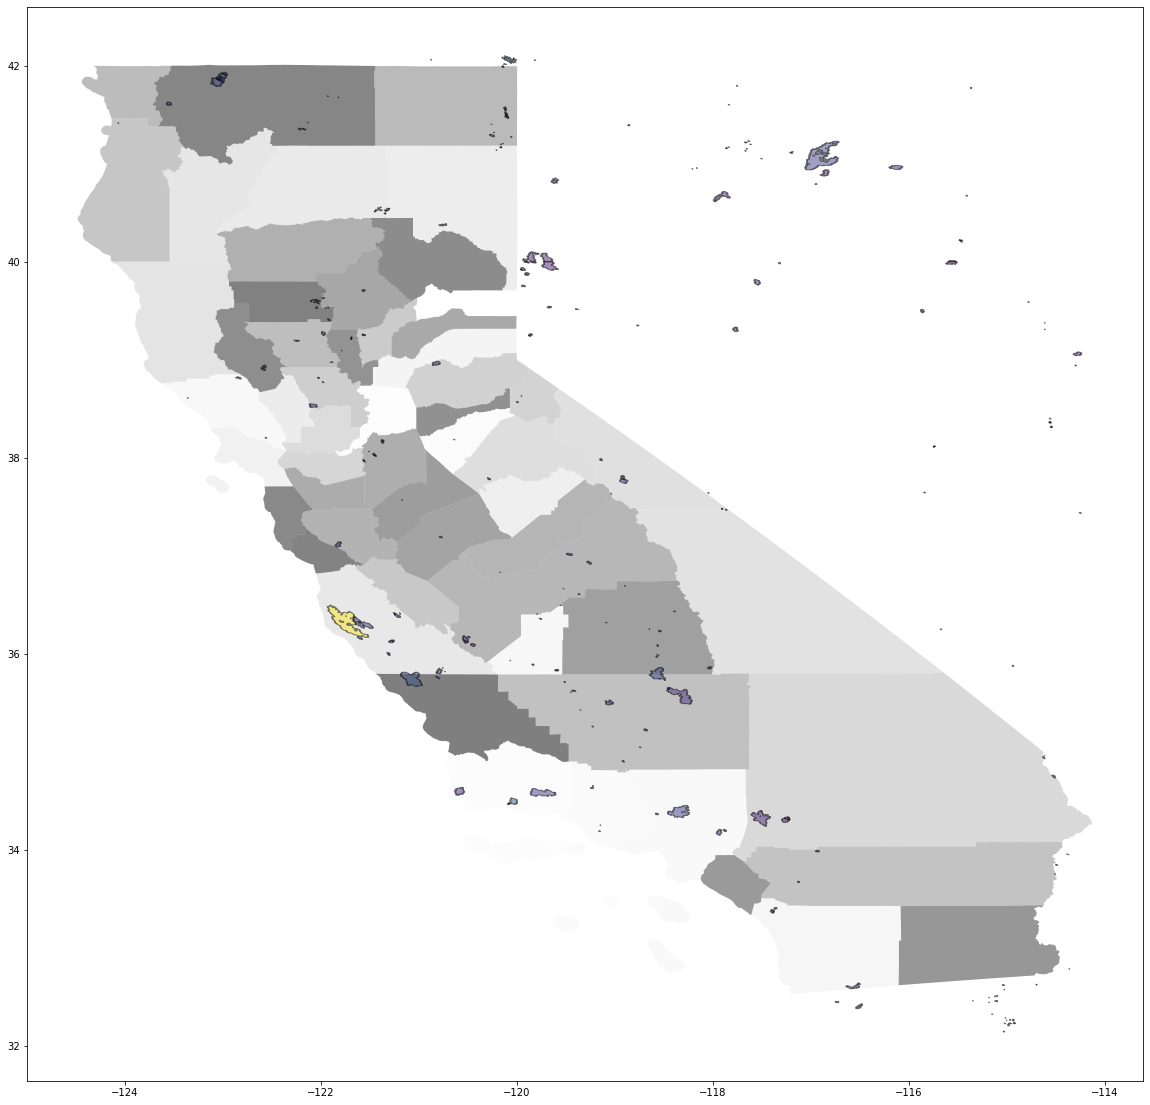

In [202]:
fig, ax = plt.subplots(figsize = (20, 20))
ca.plot(ax = ax, cmap = 'Greys', alpha = 0.5)
df_p.plot(ax = ax, column = 'duration', alpha=0.5, edgecolor='k')

In [219]:
perimeter_json = clip_poly.__geo_interface__

In [222]:
perimeter_json = clip_poly.to_json()